# RNNs in Chemical Engineering

This notebook will help the results visualization and the evaluation of the predictions.

In [2]:
import joblib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from globals import *
from mlutils import ML_utils
import scipy.stats as sts
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import r2_score, mean_absolute_error

# ignore warnings
warnings.filterwarnings('ignore')

# define plot style
sns.set_style('darkgrid')

# create preprocessing class
MEMORY_STEPS = 30           # behavior of last 3 months
PREDICTION_WINDOW = 1       # predict next week
mlu = ML_utils()

In [3]:
# read the datasets
datasets = dict()
for data in ['train', 'validation', 'test']:
    datasets[data] = pd.read_csv('../0_data/rnn_studies/{}.csv'.format(data),
        index_col=[0]
    )

In [4]:
# load training history
with open('../1_models/rnn_studies/history_75', 'rb') as hist:
    history = pickle.load(hist)

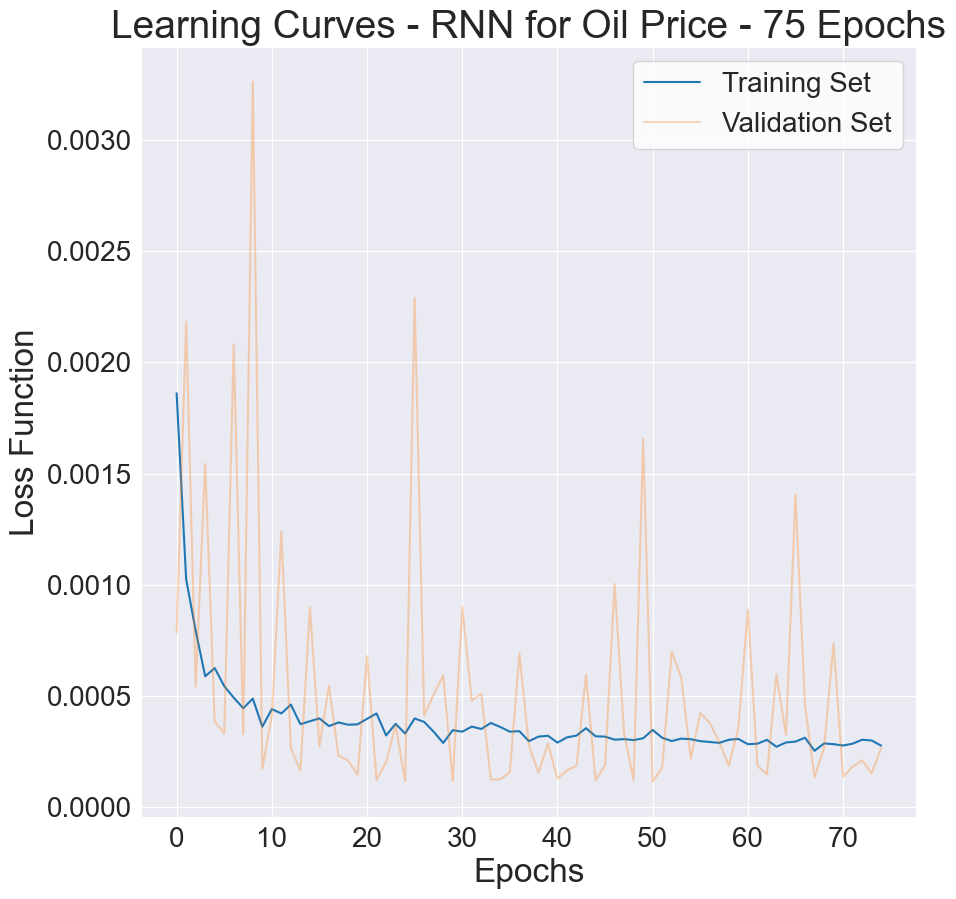

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['loss'], label='Training Set')
ax.plot(history.history['val_loss'], label='Validation Set', alpha=0.3)
ax.set_xlabel('Epochs', size=24)
ax.set_ylabel('Loss Function', size=24)
ax.set_title('Learning Curves - RNN for Oil Price - 75 Epochs', size=28)
# ax.set_ylim([0, 0.01])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20}, facecolor='white')
plt.savefig('../4_imgs/rnn_studies/epochs_75.png', dpi=500, bbox_inches='tight')

In [6]:
# transform the history into dataframe to calculate moving average
loss_data = pd.DataFrame(history.history['val_loss'], columns=['validation_loss'])
loss_data.head()

,validation_loss
0,0.000786
1,0.002182
2,0.000541
3,0.001544
4,0.000385


<Axes: >

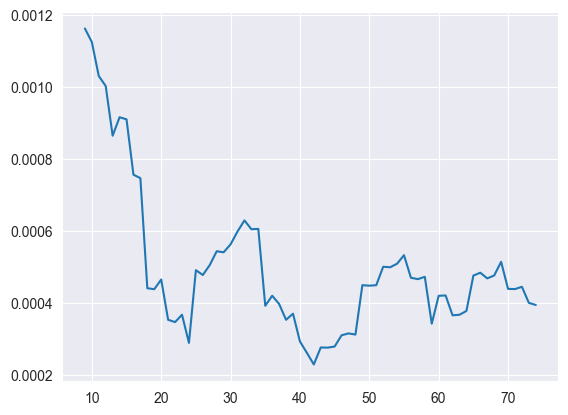

In [7]:
# calculate the moving average
periods = 10
loss_data[f'MA_{periods}'] = loss_data['validation_loss'].rolling(window=periods).mean()

# checking if validation loss presents descreasing pattern
loss_data[f'MA_{periods}'].plot()

- there's no sign of overfitting. Even with noisy behavior, the learning curve for validation sets presents a decreasing trend.

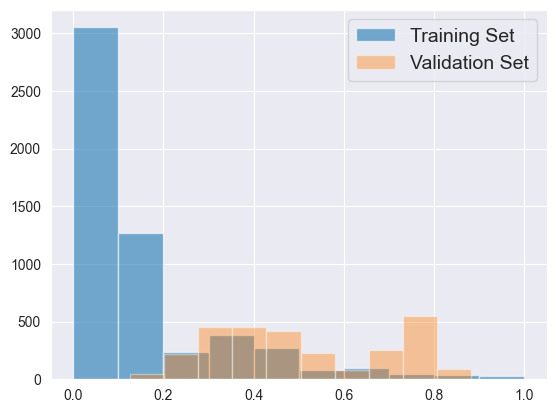

In [8]:
# check distributions of train and validation sets
plt.hist(datasets['train']['Price'], alpha=0.6, label='Training Set')
plt.hist(datasets['validation']['Price'], alpha=0.4, label='Validation Set')
plt.legend(loc='best', prop={'size': 14})

In [9]:
# load the existing RNN model and scaler
model = load_model('../1_models/rnn_studies/modelRNN_75.h5')
scaler = joblib.load('../1_models/rnn_studies/scaler.m')

In [10]:
# concatenate all dataset
full_data = pd.DataFrame()
for data in datasets:
    full_data = pd.concat([full_data, datasets[data]])

full_data.shape

(9011, 1)

In [11]:
full_data.tail()

,Price
717,0.650723
718,0.622544
719,0.631442
720,0.647164
721,0.626548


In [12]:
# apply the transformation made before testing
x, y = mlu.create_lag_structure(
    data=full_data.values,
    memory_steps=MEMORY_STEPS,
    future_steps=PREDICTION_WINDOW
)

In [13]:
# use the model to predict the results
yhat = model.predict(x)

281/281 [==============================] - 7s 14ms/step


In [14]:
# scale yhat and y back to original values
y_real = scaler.inverse_transform(y.reshape(-1, 1))
yhat = scaler.inverse_transform(yhat.reshape(-1, 1))

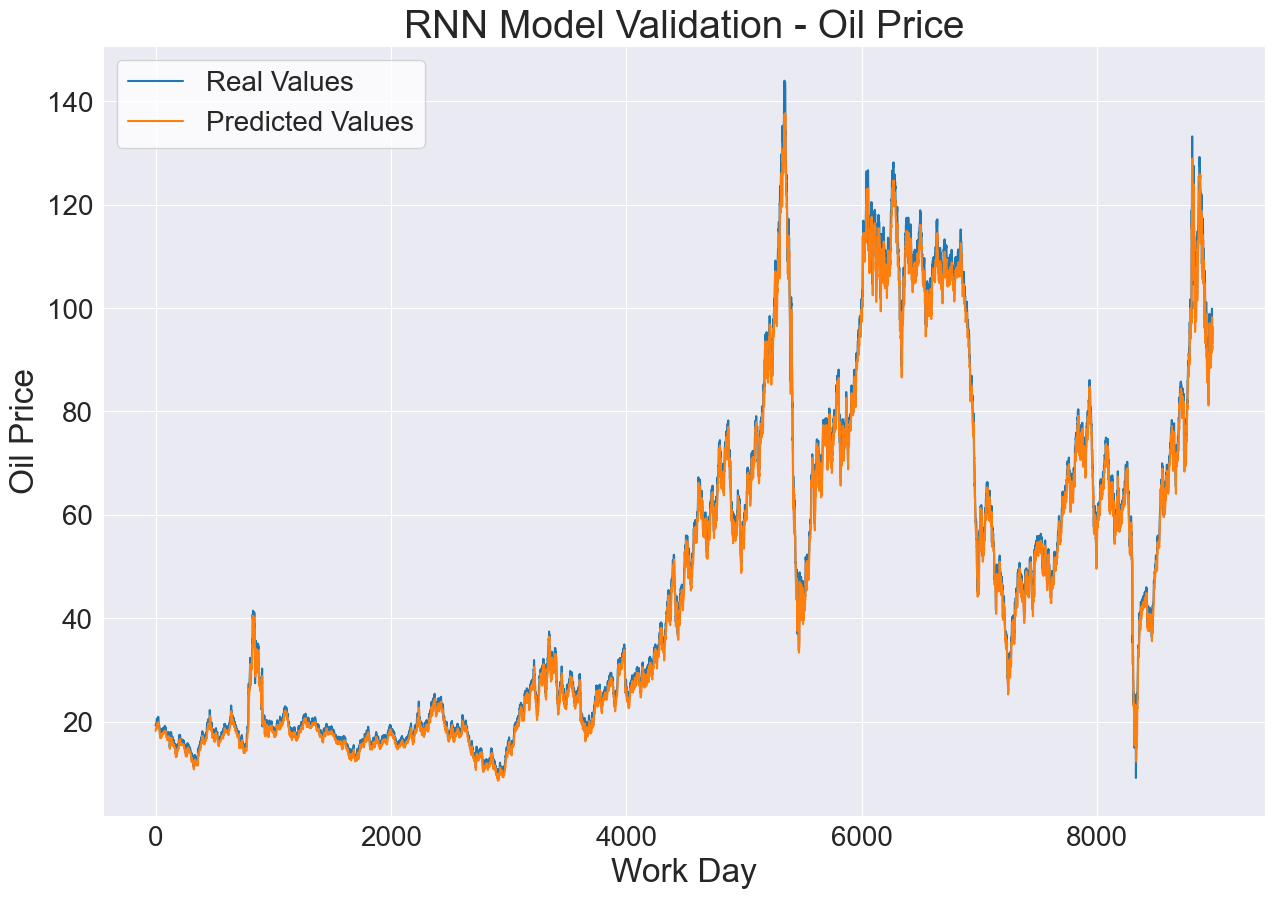

In [15]:
# create a figure to see the predictions
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(y_real, label='Real Values')
ax.plot(yhat, label='Predicted Values')
ax.set_xlabel('Work Day', size=24)
ax.set_ylabel('Oil Price', size=24)
ax.set_title('RNN Model Validation - Oil Price', size=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20}, facecolor='white')
plt.savefig('../4_imgs/rnn_studies/prediction_rnn.png', dpi=500, bbox_inches='tight')

In [16]:
# evaluate the metrics
print('R2 Score: {}'.format(round(r2_score(y_real, yhat), 4)))
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(y_real, yhat), 4)))

R2 Score: 0.9971
Mean Absolute Error: 1.362


In [44]:
# evaluate the range of errors
print(y_real.max() - y_real.min())

134.85


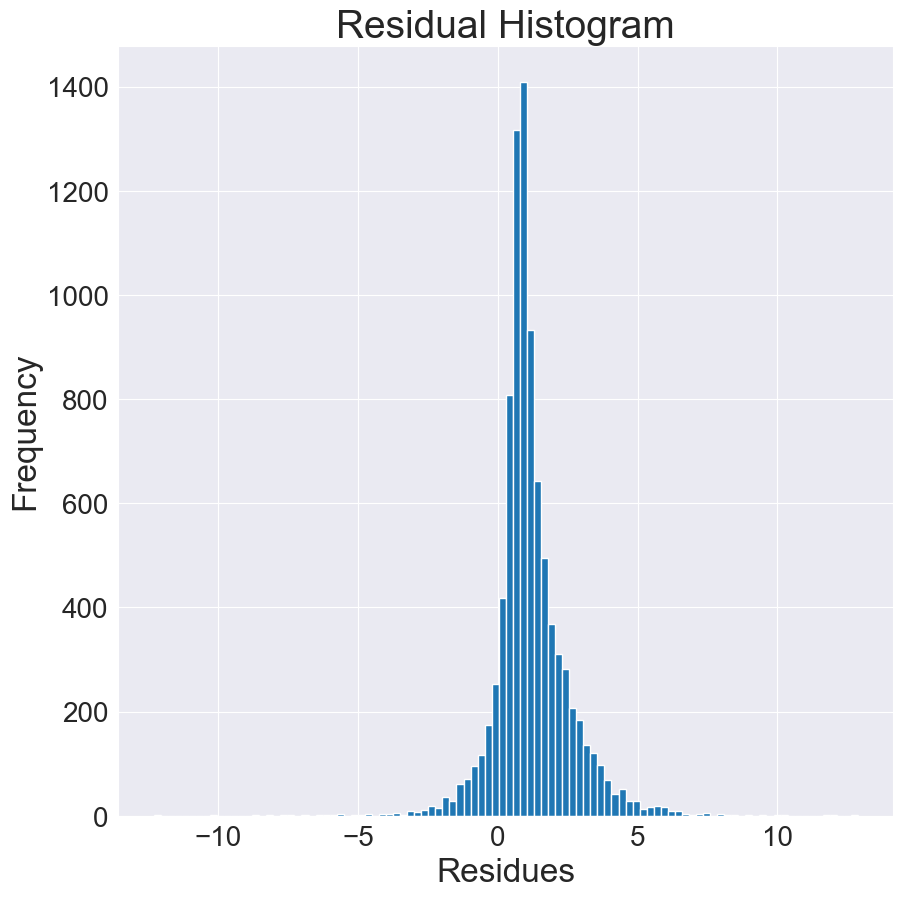

In [17]:
# let's analyze the error distribution
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.hist(y_real - yhat, bins=100)
ax.set_xlabel('Residues', size=24)
ax.set_ylabel('Frequency', size=24)
ax.set_title('Residual Histogram', size=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('../4_imgs/rnn_studies/residual_histogram.png', dpi=500, bbox_inches='tight')

In [37]:
# estimate the confidence interval
alpha= 0.01
error_analysis = np.quantile((y_real-yhat), q=[(alpha/2), 0.5, 1-(alpha/2)])

In [38]:
error_analysis

array([-2.97261657,  0.95618456,  6.13802688])

In [39]:
# define configuration for forecast
model_config = dict(
    scaler=scaler,
    model=model,
    low=error_analysis[1] - error_analysis[0],
    high=error_analysis[2] - error_analysis[1],
    mean=error_analysis[1],
    alpha=alpha
)

In [40]:
# test forecast
FUTURE = 30
forecast = mlu.forecast(n=FUTURE, model_config=model_config, x=x[-1:])

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 21ms/step


In [41]:
# load forecast results
forecast_true = pd.read_csv('../0_data/rnn_studies/forecast.csv', sep=';', decimal=',')
forecast_true.head()

,Date,Price
0,"nov 14, 2022",93.59
1,"nov 15, 2022",94.30
2,"nov 16, 2022",92.61
3,"nov 17, 2022",91.00
4,"nov 18, 2022",88.93


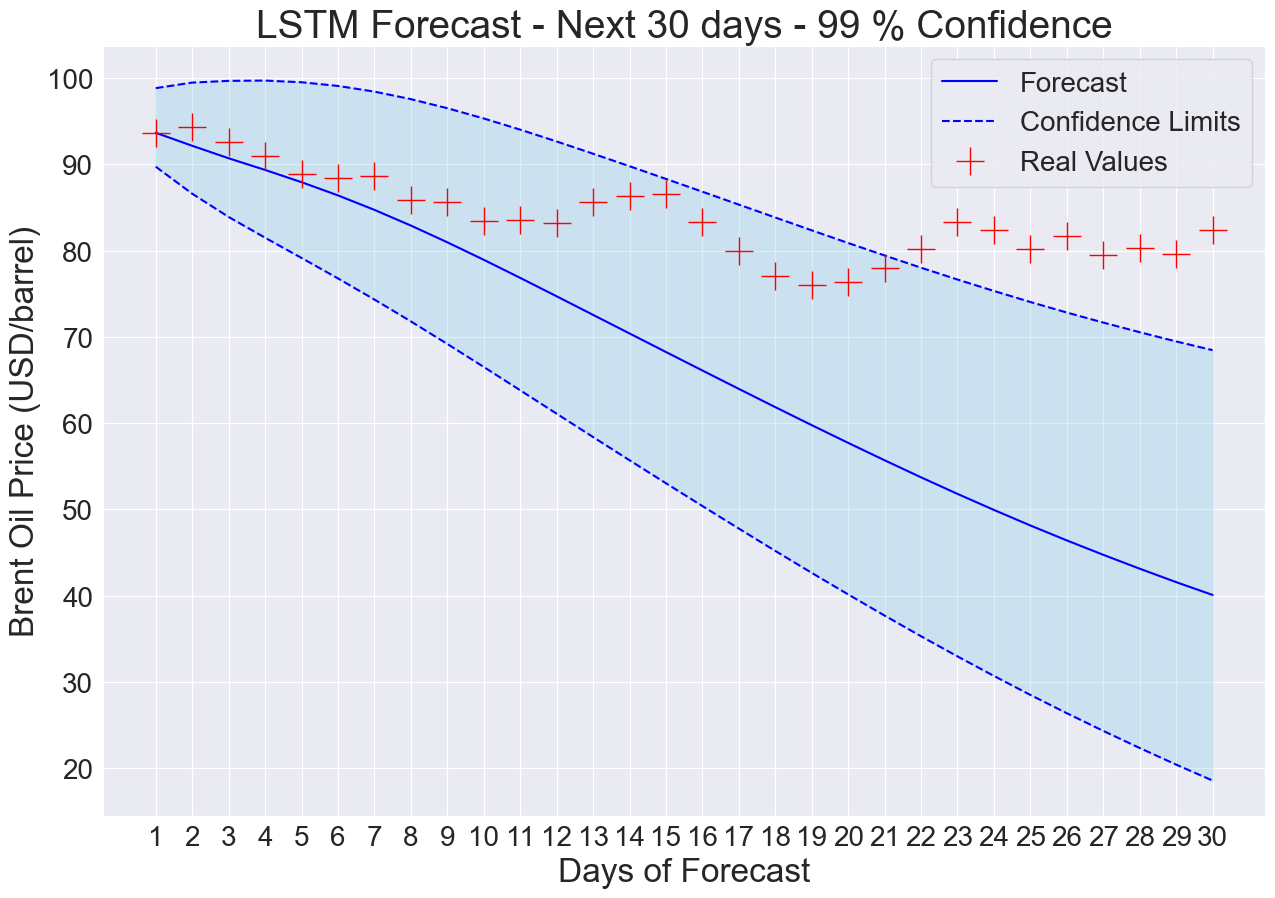

In [42]:
confidence = int(100 * (1 - alpha))

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(forecast.index+1, forecast['Predictions'], 'b-', label='Forecast')
ax.plot(forecast.index+1, forecast['+{}%'.format(confidence)], 'b--', label='Confidence Limits')
ax.plot(forecast.index+1, forecast['-{}%'.format(confidence)], 'b--')
ax.plot(forecast_true.head(FUTURE).index+1, forecast_true.head(FUTURE)['Price'],
        'r+', markersize=20, label='Real Values')
ax.fill_between(forecast.index+1, forecast['+{}%'.format(confidence)], forecast['-{}%'.format(confidence)], 
                color='skyblue', alpha=0.3)
ax.set_xlabel('Days of Forecast', size=24)
ax.set_ylabel('Brent Oil Price (USD/barrel)', size=24)
ax.set_title('LSTM Forecast - Next {} days - {} % Confidence'.format(FUTURE, confidence), size=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xticks(ticks=range(1, FUTURE+1))
ax.set_xticklabels(labels=range(1, FUTURE+1))
ax.legend(loc='best', prop={'size': 20})
# ax.set_ylim([0, 100])
plt.savefig('../4_imgs/rnn_studies/{}_forecast_{}.png'.format(FUTURE, confidence), 
            dpi=500, bbox_inches='tight')